In [12]:

from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import os
import torch
from torchvision.utils import make_grid

In [13]:
breed = "data/breed.csv"
filename = "data/labels.csv"
labelsNames = ["id", "breed"]
labels = read_csv(filename, names=labelsNames)

breedNames = read_csv(breed)["breed"].tolist()
print(labels.shape)


(12001, 2)


In [14]:
le = LabelEncoder()
le.fit(list(set(labels["breed"].tolist()[1:])))
data_label = le.transform(labels["breed"].tolist()[1:])
print(len(data_label))

12000


In [15]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Lambda(lambda img: img.convert("RGB")),
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),  # Add random rotation
            # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),  # Add color jitter
            # transforms.RandomGrayscale(p=0.1),  # Randomly convert some images to grayscale
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Lambda(lambda img: img.convert("RGB")),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
}

In [16]:
from sklearn.model_selection import train_test_split

labels_files = labels["id"].apply(lambda x: os.getcwd()+"/data/train/" + x + ".jpg").tolist()[1:]
train_path, val_path, train_label, val_label = train_test_split(
    labels_files, data_label, test_size=0.1
)


In [17]:
from torch.utils.data import Dataset
from skimage import io  # Assuming you are using skimage to read images

class DogDataset(Dataset):
    def __init__(self, data_path, data_label, transform=None):
        """
        - data_path (string): Path to the images
        - data_label (string): Labels for the images
        - transform (callable, optional): A function/transform to apply to each sample
        """
        self.data_path = data_path
        self.data_label = data_label
        self.transform = transform

    def __len__(self):
        return len(self.data_path)

    def __getitem__(self, idx):
        img_path = self.data_path[idx]
        image = io.imread(img_path)
        label = self.data_label[idx]

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, label

In [18]:
train_dataset = DogDataset(train_path, train_label, data_transforms["train"])
val_dataset = DogDataset(val_path, val_label, data_transforms["val"])


# 训练数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True,pin_memory=True )
# 验证数据加载器
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False,pin_memory=True)


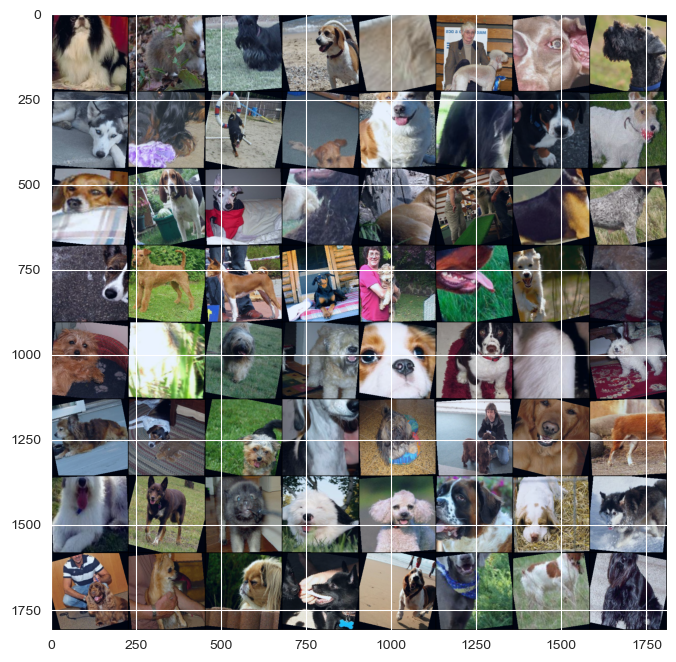

In [19]:

for batch_index, sample_batch in enumerate(train_loader):
    images, labels = sample_batch
    sample_images = make_grid(images, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(sample_images.permute(1, 2, 0).numpy())
    break

In [20]:
from torchvision import models

convnext = models.convnext_large(weights='IMAGENET1K_V1')
convnext

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [21]:
for param in convnext.parameters():
    param.requires_grad = False
    # print(param.requires_grad)
    
# 
# for layer in list(convnext.features.children())[-1:]:
#     for param in layer.parameters():
#         param.requires_grad = True



for param in convnext.parameters():
    # param.requires_grad = False
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [22]:
classifier = list(convnext.classifier.children())  # Get all layers of the classifier
classifier[-1] = torch.nn.Linear(1536, 120)  # Replace the last layer with Linear(1536, 120)
classifier.append(torch.nn.Softmax(dim=1))  # Add a Softmax layer
convnext.classifier = torch.nn.Sequential(*classifier)  # Update the original classifier
convnext

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [23]:
dev = torch.device("cuda") 

In [24]:
from adabound import adabound
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, classes, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.classes = classes
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1.0 - self.smoothing
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.classes - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), confidence)
        return torch.mean(torch.sum(-true_dist * torch.log_softmax(pred, dim=-1), dim=-1))

criterion = LabelSmoothingLoss(classes=120, smoothing=0.1)

# optimizer = torch.optim.Adam(
#     filter(lambda p: p.requires_grad, convnext.parameters()), lr=0.00005
# )  # Optimizer
# # Learning rate decay: after every 1 iteration, decay learning rate by a factor of 0.9995
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9995)

optimizer = torch.optim.AdamW(convnext.parameters(), lr=0.0001, weight_decay=1e-4)
# optimizer = adabound.AdaBound(convnext.parameters(), lr=1e-3, final_lr=0.1)

# Define CosineAnnealingWarmRestarts learning rate scheduler
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

criterion, optimizer, scheduler

(LabelSmoothingLoss(),
 AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.0001
     lr: 0.0001
     maximize: False
     weight_decay: 0.0001
 ),
 <torch.optim.lr_scheduler.CosineAnnealingWarmRestarts at 0x26450374eb0>)

In [25]:
# import random
# import torch
# import numpy as np
# 
# def mosaic_data(images, labels, input_size=224):
#     """
#     Generate new images and labels using the Mosaic data augmentation technique.
#     :param images: Tensor of images in the current batch, shape [batch_size, channels, height, width]
#     :param labels: Tensor of labels in the current batch
#     :param input_size: Target size of the output image
#     :return: Augmented images and labels
#     """
#     batch_size, channels, height, width = images.size()
#     new_image = torch.zeros((batch_size, channels, input_size, input_size), device=images.device)
#     new_labels = torch.zeros((batch_size,), dtype=torch.long, device=labels.device)
# 
#     for i in range(batch_size):
#         # Randomly select four images
#         indices = torch.randperm(batch_size)[:4]
#         selected_images = images[indices]
#         selected_labels = labels[indices]
# 
#         # Define the size of each region to be cut
#         cut_x = random.randint(int(input_size * 0.4), int(input_size * 0.6))
#         cut_y = random.randint(int(input_size * 0.4), int(input_size * 0.6))
# 
#         # Stitch four images together into one image
#         new_image[i, :, :cut_y, :cut_x] = selected_images[0, :, :cut_y, :cut_x]
#         new_image[i, :, :cut_y, cut_x:] = selected_images[1, :, :cut_y, cut_x:]
#         new_image[i, :, cut_y:, :cut_x] = selected_images[2, :, cut_y:, :cut_x]
#         new_image[i, :, cut_y:, cut_x:] = selected_images[3, :, cut_y:, cut_x:]
# 
#         # The corresponding label is chosen randomly
#         new_labels[i] = selected_labels[random.randint(0, 3)]
# 
#     return new_image, new_labels

In [26]:
import torch
from torch.amp import GradScaler, autocast
import os
from tqdm import tqdm

epochs = 100
model = convnext.to(dev)
print("Start Training...")

# Variable to store the best model
best_accuracy = 0.0
best_model_path = "models/best_convnext.pt"
patience = 10  # Number of epochs to wait for early stopping
early_stop_counter = 0

if os.path.exists("models/convnext.pt"):  # Check if a pre-trained model exists
    model_saved = convnext.to(dev)
    model_saved.load_state_dict(torch.load("models/convnext.pt"))
    model = model_saved.to(dev)
    print("Load model from convnext.pt")

# Initialize GradScaler
scaler = GradScaler("cuda")

for epoch in range(epochs):
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images = images.to(dev)
        labels = labels.to(dev)

        optimizer.zero_grad()
        
        # if np.random.rand() < 0.5:
        #     images, labels = mosaic_data(images, labels, input_size=224)
        # Use autocast for forward and backward pass
        with autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels.type(torch.int64))

        # Use GradScaler to scale the loss and perform backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()  # Update the scaler

        if (i + 1) % 100 == 0:
            print(
                "Epoch [{}/{}], Batch [{}/{}], Train loss: {:.3f}".format(
                    epoch + 1, epochs, i + 1, len(train_loader), loss.item()
                )
            )
    
    model.eval()  # Ensure the model is in evaluation mode
    correct = 0
    total = 0
    if epoch % 10 == 0:
        print("Save model to convnext.pt")
        torch.save(model.state_dict(), "models/convnext.pt")

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(dev)
            labels = labels.to(dev)

            with autocast("cuda"):
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    accuracy = correct / total
    print("============ Test accuracy: {:.3f} =============".format(accuracy))
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with accuracy: {best_accuracy:.3f}")
        early_stop_counter = 0  # Reset the early stopping counter
    else:
        early_stop_counter += 1

    scheduler.step()  # Apply learning rate decay

Start Training...


C:\Users\17164\AppData\Local\Temp\ipykernel_9140\3889631584.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_saved.load_state_dict(torch.load("models/convnext.pt")

Load model from convnext.pt


9it [00:07,  1.28it/s]


KeyboardInterrupt: 

In [27]:
torch.save(model.state_dict(), "models/convnext.pt")

In [28]:
from PIL import Image
IMAGE = io.imread("data/train/0AjbbdBwNiGqWo5n.jpg")
IMAGE = data_transforms["val"](IMAGE).unsqueeze(0)  

IMAGE.size()


torch.Size([1, 3, 224, 224])

In [34]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def visualize_inference_errors(model, val_loader, label_encoder, device):
    model.eval()  # Set the model to evaluation mode
    errors = []  # List to store misclassified samples
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Model prediction
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Find the indices of misclassified samples
            error_indices = (predicted != labels).nonzero(as_tuple=True)[0]
            
            # Record the information of misclassified samples
            for idx in error_indices:
                errors.append((images[idx].cpu(), labels[idx].cpu(), predicted[idx].cpu()))

    # Visualize misclassified samples
    if errors:
        print(f"Number of misclassified samples: {len(errors)}")
        
        # Display the first few misclassified samples
        num_samples_to_show = min(len(errors), 16)  # Show up to 16 samples
        fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
        fig.suptitle("Misclassified Samples", fontsize=16)
        
        for i in tqdm(range(num_samples_to_show)):
            img, true_label, pred_label = errors[i]
            img = img.permute(1, 2, 0)  # Rearrange the dimensions to H*W*C for display
            img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # De-normalize
            
            ax = axes[i // 4, i % 4]
            ax.imshow(img.numpy())
            ax.set_title(f"True: {label_encoder.inverse_transform([true_label.item()])[0]}\nPred: {label_encoder.inverse_transform([pred_label.item()])[0]}")
            ax.axis("off")
        
        plt.tight_layout()
        plt.show()
    else:
        print("No misclassified samples found.")

In [35]:
visualize_inference_errors(convnext, val_loader, le, dev)

 42%|████▏     | 8/19 [00:07<00:09,  1.14it/s]


KeyboardInterrupt: 

In [31]:
def predict_with_augmentation(image):
    flips = [image, image.flip(-1)]
    outputs = []
    for flip in flips:
        outputs.append(model(flip.to(dev)))
    return torch.mean(torch.stack(outputs), dim=0)




data = predict_with_augmentation(IMAGE)

tempDict = {}
for i in tqdm(range(len(data[0]))):
    tempDict[le.inverse_transform([i])[0]] = data[0][i].item()
temp=pd.DataFrame(tempDict,index=[0])
temp.insert(0,"id","0AjbbdBwNiGqWo5n")
temp

100%|██████████| 120/120 [00:00<00:00, 1475.88it/s]


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0AjbbdBwNiGqWo5n,0.000001,6.320810e-07,8.785067e-07,0.000001,6.842312e-07,0.000003,0.000002,0.000002,6.370369e-07,...,0.000002,1.260111e-07,0.000001,0.000003,0.000001,0.000002,0.000005,0.000002,3.516874e-07,0.000002


In [ ]:
outdata= pd.DataFrame(columns=["id"]+breedNames)
outdata
testPath = os.getcwd()+"/data/test/"
files= os.listdir(testPath)

p=0

for file in tqdm(files):
    p+=1
    IMAGE = io.imread(testPath+file)
    IMAGE = data_transforms["val"](IMAGE).unsqueeze(0)
    # data= model_saved(IMAGE.to(dev))
    data = predict_with_augmentation(IMAGE)
    tempDict = {}
    for i in range(len(data[0])):
        tempDict[le.inverse_transform([i])[0]] = data[0][i].item()
    temp=pd.DataFrame(tempDict,index=[0])
    temp.insert(0,"id",file[:-4])
    outdata=pd.concat([outdata,temp],ignore_index=True)
outdata

In [ ]:
output_path = "out/outputConvNextV12.csv" 
columns_sorted = ["id"] + sorted(col for col in outdata.columns if col != "id")
outdata = outdata[columns_sorted]
outdata.to_csv(output_path, index=False) 